In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# check if a GPU is available for pytorch
torch.cuda.is_available()

True

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [3]:
batch_size_train = 64 

batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
          transform=torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize( 
                  (0.1307,), (0.3081,)),
                             
          ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
          transform=torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,)),
          ])),
    batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [4]:
examples = list(train_loader)
example_data, example_targets = examples[0]
print(example_data.shape)
print(example_targets.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


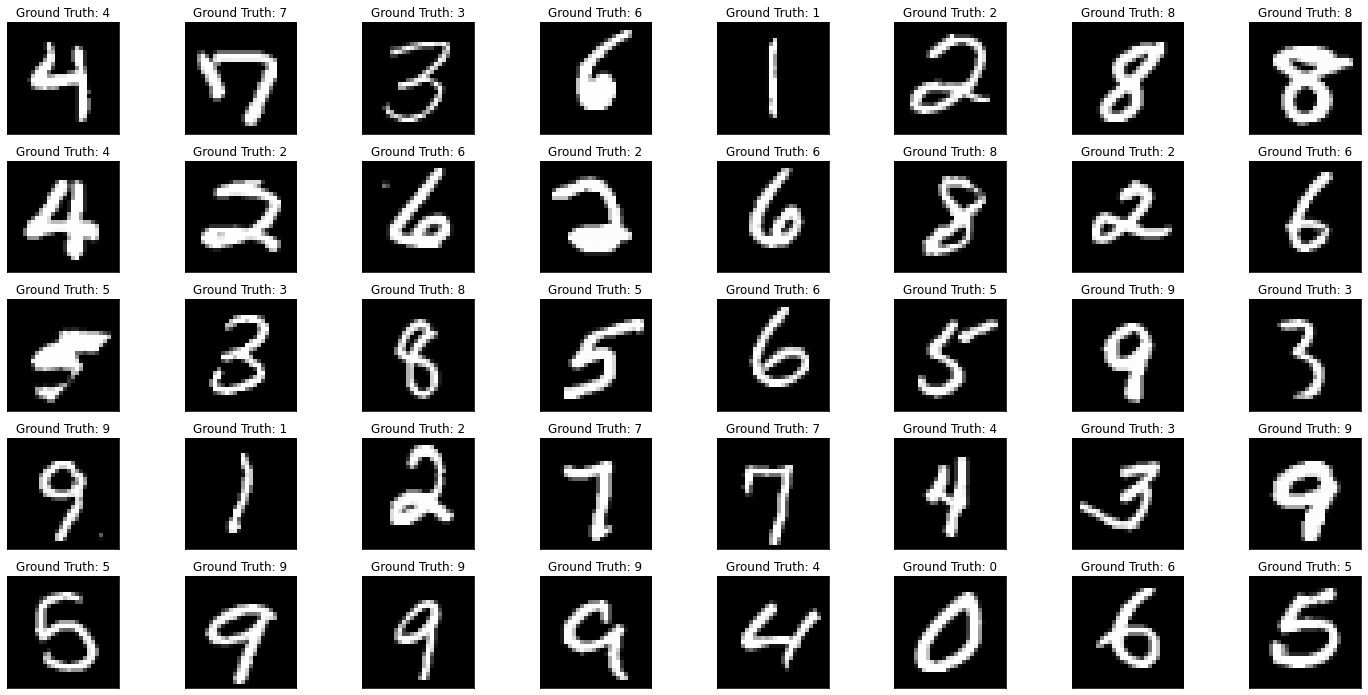

In [5]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

We define the network

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=(2,2))
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(720, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 720)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [7]:
learning_rate = 0.01

network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [8]:
n_epochs = 3  # 3 epochs

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

This is the main training loop.

In [9]:
for data, target in test_loader:
    data = data.to(DEVICE)
    target = target.to(DEVICE)
    output = network(data)

<ipython-input-6-586a4b3495a5>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [10]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

This is the main testing loop.

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We define 2 variables `test_loss` and `correct` equal to 0 which work as counters. We pass our data to the function and to the model to have the predictions. From the targets and predictions we compute the cross entropy loss.\
Then we check if the predictions are equal to the target values and we add the to the `correct` counter We normalize the counters to 100 and print them.   

Training

In [12]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-6-586a4b3495a5>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3102, Accuracy: 726/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288541
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.931532
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.289669
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.075958
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.976703
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.869506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.915855
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.029423
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.996573
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.960476
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.780305
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.767916
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.511639
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.567594
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.354755
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.842076
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.576877
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.615564
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.620115
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

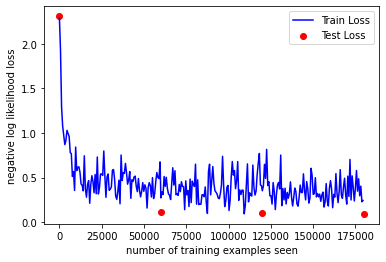

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [14]:
with torch.no_grad():
    output = network(example_data.to(DEVICE))

<ipython-input-6-586a4b3495a5>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


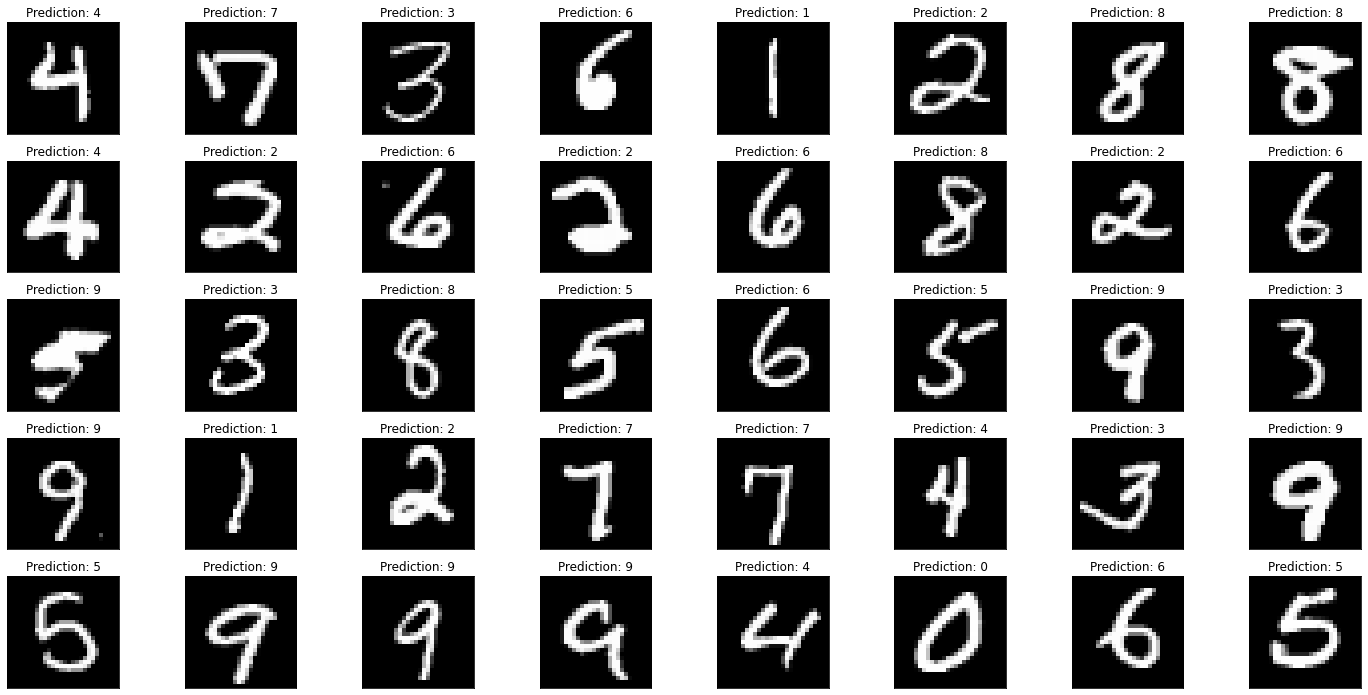

In [15]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
      output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

Our model has an accuracy of 96-97% The initital accuracy is low because the predictions are totally random and the probability of predicting an image correct is 1 out of 10, so the expected accuracy is around 10%